## Imports and preliminaries

In [21]:
import sys, os

sys.path.append(os.path.join(os.getcwd(), '../src'))
os.environ["CUDA_MODULE_LOADING"] = "LAZY"

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
import random

import splitConformalPrediction
from folktables import (
    ACSDataSource,
    BasicProblem,
    adult_filter,
    state_list,
    travel_time_filter,
)
from CalibrationScorers.customAPSCalibrationScorer import customAPSCalibrationScorer
from MultivalidAlgorithms.MultivalidCoverage import multivalid_coverage, eval_fn
from DatasetGeneration.DivisibleDataset import divisible_dataset
from MultivalidAlgorithms.GroupCoverage import group_coverage

from utils.data_utils import get_custom_dataset
from utils.constants import *


In [6]:
seed = 0

os.environ["PL_GLOBAL_SEED"] = str(seed)
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
    
torch.set_float32_matmul_precision("medium")

In [22]:
class dotdict(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__

# SET DATASET AND EXTRA ARGS HERE
DATASET = POKEC_N
SENS_ATTRS = ["gender"]
DATASET_ARGS = dotdict({"binary_sens": False, "small_class": False})

In [25]:
graph = get_custom_dataset(DATASET, "./datasets", sens_attrs=SENS_ATTRS, dataset_args=DATASET_ARGS, force_reprep=True)[0]
features, labels, groups = graph.ndata[FEATURE_FIELD], graph.ndata[LABEL_FIELD], graph.ndata[SENS_FIELD]
node_ids = torch.nonzero(labels + 1, as_tuple=True)[0]
features, labels, groups = features[node_ids], labels[node_ids], groups[node_ids]

In [9]:
def produce_group(feat_index, feat_value):
    '''
        Input: 
            - feat_index: index of desired input feature
            - feat_value: desired value of that feature
        Output:
            - f - function which defines a group; f(x) returns True
                  iff x[feat_index] == feat_value and returns False otherwise.
    '''
    def f(x):
        return (x[feat_index] == feat_value)
    
    return f

group_list = list()
# From FolksTable Census data,
# 1. White
# 2. Black / African-American
# 3. American Indian - very few
# 4. Alaska Native - extremely few
# 5. American Indian - also very minimal (slightly more than 4.) 
# 6. Asian
# 7. Native Haiwaan and Other Pacific Islander - very few
# 8. Some other race (one)
# 9. Two or more races

if "ACS" in DATASET:
    list_of_sens_attrs = [1, 2, 3, 4, 5, 6, 7, 8, 9]
else: 
    list_of_sens_attrs = torch.unique(groups).to(torch.int).tolist()
num_groups = len(list_of_sens_attrs)
for j in list_of_sens_attrs:
    if DATASET == ACS_INCOME:
        idx = 9
    elif DATASET == ACS_EDUC:
        idx = 8
    else:
        idx = -1
    curr_group_fun = produce_group(idx, j)
    group_list.append(curr_group_fun)

def all_points(x):
    return True

basic_group = [all_points]
num_groups_basic = 1

group_fn_list =(lambda x: [group(x) for group in group_list])

In [10]:
node_ids_dev, node_ids_cal_test, features_dev, features_cal_test, label_dev, label_cal_test, group_dev, group_cal_test = train_test_split(node_ids, features, labels, groups, train_size = 0.5, shuffle = True, stratify=list(zip(labels, groups)),random_state = 0)

node_ids_train, node_ids_valid, X_train, X_valid, y_train, y_valid, group_train, group_valid = train_test_split(node_ids_dev, features_dev, label_dev, group_dev, train_size = 0.6, shuffle = True, stratify=list(zip(label_dev, group_dev)),random_state = 0)

node_ids_calib, node_ids_test, X_calib, X_test, y_calib, y_test, group_calib, group_test = train_test_split(node_ids_cal_test, features_cal_test, label_cal_test, group_cal_test, train_size = 0.5, shuffle = True, stratify=list(zip(label_cal_test, group_cal_test)), random_state = 0)

training_size, numFeatures = np.shape(X_train)

# Separate training data into training (for point-predictor) and calibration
print(f"Number of Training Points: {training_size}")
print(f"Number of Validation Points: {len(y_valid)}")
print(f"Number of Calibration Points: {len(y_calib)}")
print(f"Number of Test Points: {len(y_test)}")

Number of Training Points: 2638
Number of Validation Points: 1760
Number of Calibration Points: 2199
Number of Test Points: 2200


# Load base model probs

In [11]:
# Parameters for our uncertainty quantifier(s)
tau = 0.9
delta = 1 - tau
num_grid = 300

In [13]:
probs_calib = None
probs_test = None

SENS_PREFIX = ("_".join([""] + SENS_ATTRS)).rstrip("_")

# Load in prob and labels
if DATASET in [ACS_INCOME, ACS_EDUC, CREDIT]:
    res = torch.load(f"/home/vadlamani.12/DMRL/AVOIRPlusPlus/outputs/{DATASET}/hpt_{DATASET}_xgb/all_prob_labels.pt", weights_only=False)
elif DATASET in [POKEC_N, POKEC_Z]:
    if SENS_PREFIX == "_region_gender":
        SENS_PREFIX = ""
    res = torch.load(f"/home/vadlamani.12/DMRL/AVOIRPlusPlus/outputs/{DATASET}/split/0.3_0.2{SENS_PREFIX}/{DATASET}/best_{DATASET}_split_0.3_0.2{SENS_PREFIX}/all_prob_labels.pt", weights_only=False)
else:
    raise NotImplemented(f"{DATASET} not currently implemented")

probs = res["probs"]
probs_calib = probs[node_ids_calib, :]
probs_test = probs[node_ids_test, :]

# Computer scores for calibration and test points

In [14]:
# Convert y_calib values into threshold values in order to train for conformal prediction 
from CalibrationScorers.customAPSCalibrationScorer import customAPSCalibrationScorer
import math

num_batches = 100

apsCalibrationScorer = customAPSCalibrationScorer()

apsCalibrationScorer.update(lambda x: x)

calibration_set_size = len(y_calib)
test_set_size = len(y_test)

print("Getting calibration scores...")
calib_per_batch = math.ceil(calibration_set_size / num_batches)
input_calib = X_calib
if probs_calib is not None:
    input_calib = probs_calib.numpy()

w_calib = np.concatenate([apsCalibrationScorer.calc_score(input_calib[i * calib_per_batch: (i + 1) * calib_per_batch]) for i in range(num_batches + 1)]) 
print("Got calibration scores")

print("Getting test scores...")
test_per_batch = math.ceil(test_set_size / num_batches)
input_test = X_test
if probs_test is not None:
    input_test = probs_test.numpy()
    
w_test = np.concatenate([apsCalibrationScorer.calc_score(input_test[i * test_per_batch: (i + 1) * test_per_batch]) for i in range(num_batches + 1)]) #, y_test[i * test_per_batch: (i + 1) * test_per_batch]
print("Got test scores")

Getting calibration scores...
Got calibration scores
Getting test scores...
Got test scores


In [15]:
# One-shot algorithm for group coverage
print(DATASET)

X_calib_with_sens = X_calib
if DATASET in [POKEC_N, POKEC_Z]:
    X_calib_with_sens = torch.cat((X_calib, group_calib.reshape(-1, 1)), axis=1)

group_accurate_model, opt_theta = group_coverage(tau=tau, x_train=X_calib_with_sens, y_train=w_calib[torch.arange(calibration_set_size), y_calib], num_groups=num_groups, group_fn=group_fn_list)

Pokec_n



Optimal theta found: [0.87168974 0.8872228 ]


## Plotting Results

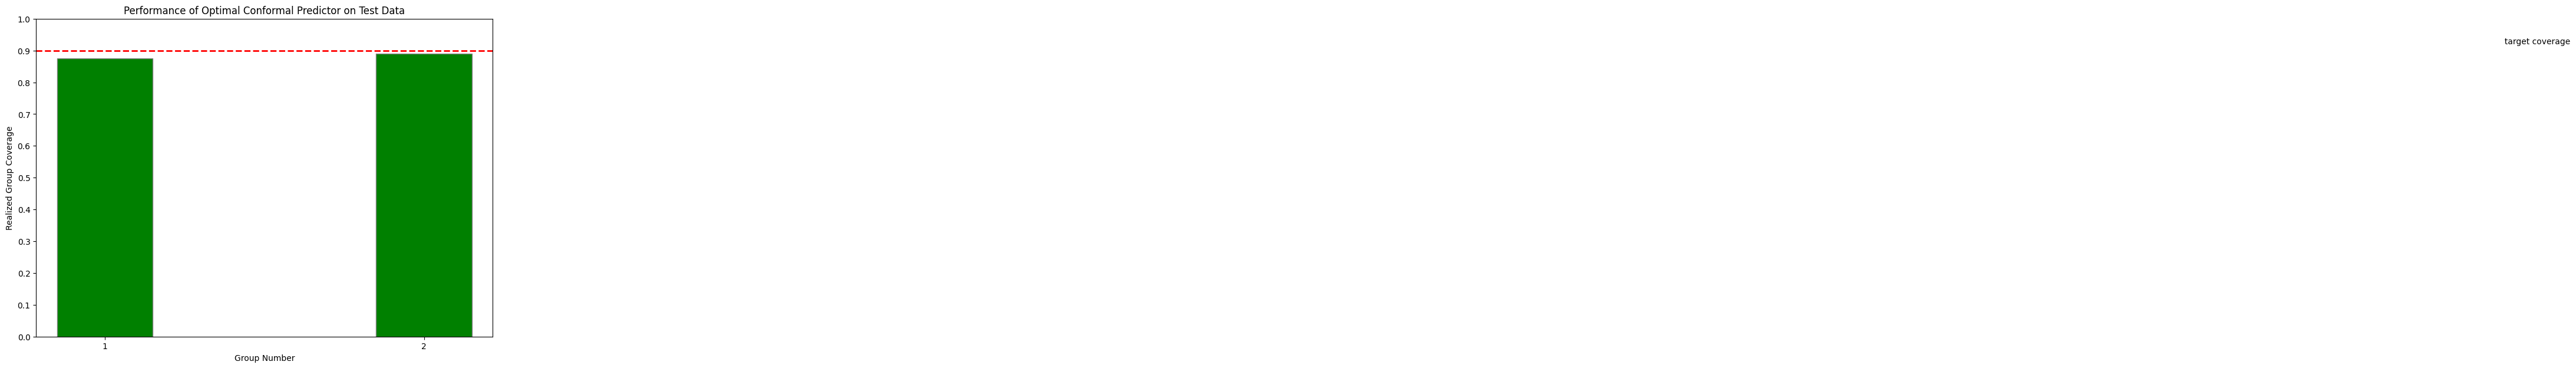

Coverage on group 1 : 0.8755144032921811
Coverage on group 2 : 0.8900651465798045


In [16]:
from utils.MultivalidPlotting import plot_group_coverage, plot_all_group_coverage

X_test_with_sens = X_test
if DATASET in [POKEC_N, POKEC_Z]:
    X_test_with_sens = torch.cat((X_test, group_test.reshape(-1, 1)), axis=1)

plot_group_coverage(model=group_accurate_model, tau=tau, x_test=X_test_with_sens, y_test=w_test[torch.arange(test_set_size), y_test], num_groups=num_groups, group_fn=group_fn_list, multivalid=False, verbose=True)

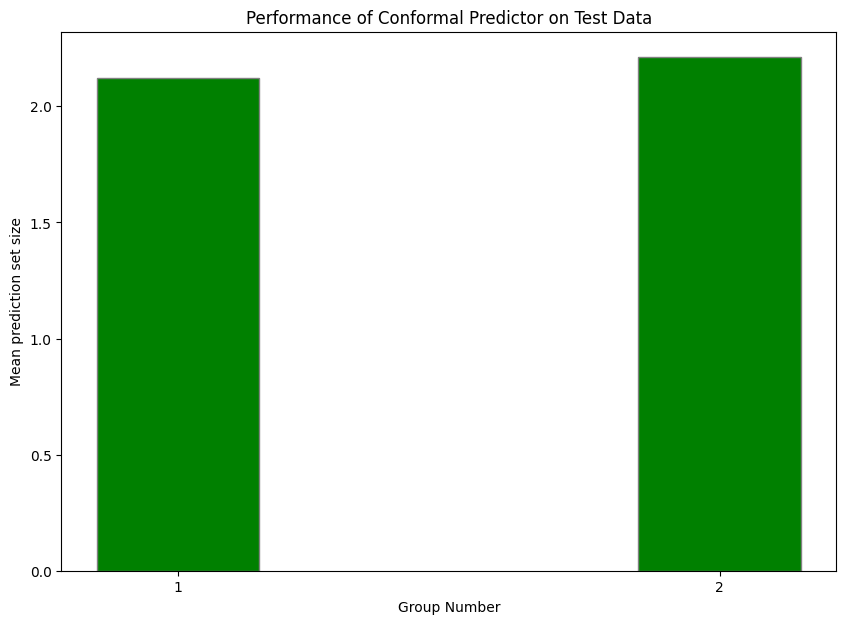

Average prediction set size on group 1 : 2.1213991769547325
Average prediction set size on group 2 : 2.210912052117264


In [17]:
from utils.MultivalidPlotting import plot_pred_set_size

X_test_with_sens = X_test
if DATASET in [POKEC_N, POKEC_Z]:
    X_test_with_sens = torch.cat((X_test, group_test.reshape(-1, 1)), axis=1)

plot_pred_set_size(model=group_accurate_model, tau=tau, x_test=X_test_with_sens, y_test=w_test, num_groups=num_groups, group_fn=group_fn_list, mult_width = 1, multivalid=False, verbose=True, mode="clf")

# Conformal Fairness Evaluation

In [18]:
from enum import Enum

FAIRNESS_METRICS = Enum(
    "FAIRNESS_METRICS",
    [
        "Demographic_Parity",
        "Disparate_Impact",
    ],
)

# Define filter function
def get_filter_mask(fairness_metric, labels, groups, pos_label, group_id):
    assert (
        labels.shape[0] == groups.shape[0]
    ), f"Got {labels.shape[0]} labels, but {groups.shape[0]} groups"

    match fairness_metric:
        case (
            FAIRNESS_METRICS.Demographic_Parity.name
            | FAIRNESS_METRICS.Disparate_Impact.name
        ):
            return (groups == group_id).reshape(-1)
        case _:
            raise NotImplementedError(
                f"Filtering function not implemented for {fairness_metric}"
            )

def set_sizes(prediction_sets):
    return prediction_sets.sum(dim=1)

def calc_coverage(prediction_sets, labels):
    includes_true_label = prediction_sets.gather(1, labels.unsqueeze(1)).squeeze()
    empirical_coverage = includes_true_label.sum() / len(prediction_sets)
    return empirical_coverage

def calc_efficiency(prediction_sets):
    empirical_efficiency = set_sizes(prediction_sets).sum() / len(prediction_sets)
    return empirical_efficiency
            
# Define unique groups and labels to be use for CF framework
all_groups = torch.unique(groups.to(torch.int))
all_labels = torch.unique(labels.to(torch.int))
pos_labels = torch.nonzero(all_labels, as_tuple=True)[0]

In [19]:
X_test_with_sens = X_test
if DATASET in [POKEC_N, POKEC_Z]:
    X_test_with_sens = torch.cat((X_test, group_test.reshape(-1, 1)), axis=1)

pred_sets = np.concatenate([w_test[i] <= group_accurate_model(X_test_with_sens[i]) for i in range(test_set_size)])
pred_sets = torch.from_numpy(pred_sets.reshape(test_set_size, -1))

In [20]:
res = {"metric": [], "eff": [], "violation": []}

res["eff"].append(calc_efficiency(pred_sets))

print("_".join([DATASET] + SENS_ATTRS))

print(f"Coverage: {calc_coverage(pred_sets, y_test)}")
print(f"Efficiency: {res['eff']}\n\n")

for metric in FAIRNESS_METRICS:
    print(metric)
    res["metric"].append(metric)
    if metric.name == FAIRNESS_METRICS.Disparate_Impact.name:
        worst_violation = float('inf')
    else:
        worst_violation = -float('inf')
        
    for label in pos_labels:
        coverages = []
        for g_i in all_groups:
            filtered_test_mask = get_filter_mask(
                metric.name, y_test, group_test, label, g_i
            )

            cov_labels = y_test[filtered_test_mask]

            cov = calc_coverage(
                pred_sets[filtered_test_mask, :], cov_labels
            )
            coverages.append(cov)

#             print(
#                 f"Positive Label Coverage for y_k = {label} and g_i = {g_i} = {cov}"
#             )
#         print()
        
        if metric.name == FAIRNESS_METRICS.Disparate_Impact.name:
#             print(f"Actual Coverage Ratio={min(coverages) / max(coverages)}\n")
            worst_violation = min(min(coverages) / max(coverages), worst_violation)
        else:
#             print(f"Actual Coverage Delta={max(coverages) - min(coverages)}\n")
            worst_violation = max(max(coverages) - min(coverages), worst_violation)
#     print()
        
    
    res['violation'].append(worst_violation)
    print(f"Worst Violation is: {worst_violation}\n")


Pokec_n_gender
Coverage: 0.8836363554000854
Efficiency: [tensor(2.1714)]


FAIRNESS_METRICS.Demographic_Parity
Worst Violation is: 0.014550745487213135

FAIRNESS_METRICS.Disparate_Impact
Worst Violation is: 0.9836520552635193

